# GOES16 Pipeline Walkthrough

In this demo, we will do a full walkthrough of a minimal GOES pipeline to get some data for training

In [1]:
import autoroot
from rs_tools._src.utils.io import get_list_filenames
import rioxarray
import xarray as xr
import pandas as pd
import numpy as np
import earthaccess
from pathlib import Path
from rs_tools._src.data.modis.bands import MODIS_VARIABLES
from rs_tools._src.geoprocessing.reproject import calc_latlon
from rs_tools._src.data.modis import MODISFileName, MODIS_ID_TO_NAME, MODIS_NAME_TO_ID, get_modis_paired_files

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from dataclasses import dataclass
from tqdm.auto import tqdm
from datetime import datetime

%matplotlib inline
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'autoroot'

In [3]:
save_dir_raw = "/home/juanjohn/data/rs/goes16/raw/"
save_dir_analysis = "/home/juanjohn/data/rs/goes16/analysis/"
save_dir_mlready = "/home/juanjohn/data/rs/goes16/mlready/"

## 1 - Download Data

In [4]:
start_date = "2018-10-01"
end_date = "2018-10-02"
start_time = "14:00:00"
end_time = "20:00:00"
instrument = "ABI"
data_product = "Rad"
processing_level = "L1b"

In [5]:
from rs_tools._src.data.goes.download import goes_download

#### Radiance Data

In [6]:
# goes_download(
#     start_date=start_date,
#     end_date=end_date,
#     start_time=start_time,
#     end_time=end_time,
#     daily_window_t0=start_time,
#     daily_window_t1=end_time,
#     data_product=data_product,
#     instrument=instrument,
#     processing_level=processing_level,
#     save_dir=save_dir_raw
# )

#### Cloud Mask

In [7]:
instrument = "ABI"
data_product = "ACM"
processing_level = "L2"

In [8]:
# goes_download(
#     start_date=start_date,
#     end_date=end_date,
#     start_time=start_time,
#     end_time=end_time,
#     daily_window_t0=start_time,
#     daily_window_t1=end_time,
#     data_product=data_product,
#     instrument=instrument,
#     processing_level=processing_level,
#     save_dir=save_dir_raw
# )

For this case, we are going to download GOES data.

**Resources**:
* GOES2GO

In [9]:
goes_files = get_list_filenames("/home/juanjohn/data/rs/goes16/raw/noaa-goes16/ABI-L1b-RadF/", ".nc")
goes_files[0], len(goes_files)

('/home/juanjohn/data/rs/goes16/raw/noaa-goes16/ABI-L1b-RadF/2018/274/14/OR_ABI-L1b-RadF-M4C01_G16_s20182741400224_e20182741405027_c20182741405078.nc',
 64)

In [10]:
# Path(goes_files[0]).name.replace("-","").split("_")

### Download Loop

## 2 - Loading Data

1. Get All Files
2. Create GOESFileName Identifiers
3. Filter Based on criteria

In [12]:
ds = xr.open_mfdataset(
    "/home/juanjohn/data/rs/goes16/raw/noaa-goes16/ABI-L1b-RadF/2018/274/14/OR_ABI-L1b-RadF-M4C01*"
)
ds

<xarray.Dataset> Size: 942MB
Dimensions:                                 (y: 10848, x: 10848,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             band: 1, num_star_looks: 24)
Coordinates:
    t                                       datetime64[ns] 8B ...
  * y                                       (y) float64 87kB 0.1519 ... -0.1519
  * x                                       (x) float64 87kB -0.1519 ... 0.1519
    y_image                                 float32 4B ...
    x_image                                 float32 4B ...
    band_id                                 (band) int8 1B dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength                         (band) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    t_star_look                             (num_star_looks) datetime64[ns] 192B dask.array<chunksize=(24,), meta=np.ndarray>
    band_wavelength_star_look               (num_star_looks) float32 96B dask.array<chunksize=(24,), meta=np.ndarray>
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band, num_star_looks
Data variables: (12/31)
    Rad                                     (y, x) float32 471MB dask.array<chunksize=(226, 226), meta=np.ndarray>
    DQF                                     (y, x) float32 471MB dask.array<chunksize=(226, 226), meta=np.ndarray>
    time_bounds                             (number_of_time_bounds) datetime64[ns] 16B dask.array<chunksize=(2,), meta=np.ndarray>
    goes_imager_projection                  int32 4B ...
    y_image_bounds                          (number_of_image_bounds) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    x_image_bounds                          (number_of_image_bounds) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                                      ...
    percent_uncorrectable_L0_errors         float32 4B ...
    earth_sun_distance_anomaly_in_AU        float32 4B ...
    algorithm_dynamic_input_data_container  int32 4B ...
    processing_parm_version_container       int32 4B ...
    algorithm_product_version_container     int32 4B ...
    star_id                                 (num_star_looks) float32 96B dask.array<chunksize=(24,), meta=np.ndarray>
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    production_data_source:    Realtime
    timeline_id:               ABI Mode 4
    date_created:              2018-10-01T14:05:07.8Z
    time_coverage_start:       2018-10-01T14:00:22.4Z
    time_coverage_end:         2018-10-01T14:05:02.7Z
    id:                        6386f771-1da9-4d21-bab8-2db1b54c6cc5

In [13]:
from rs_tools._src.geoprocessing.goes.interp import resample_rioxarray
from rs_tools._src.geoprocessing.goes.validation import correct_goes16_bands, correct_goes16_satheight
from rs_tools._src.geoprocessing.goes.reproject import add_goes16_crs
from rs_tools._src.geoprocessing.reproject import convert_lat_lon_to_x_y


In [14]:
ds_c = correct_goes16_satheight(ds)
ds_c = correct_goes16_bands(ds_c)
ds_c = add_goes16_crs(ds_c)

# subset data
bbox = (-130, -15, -90, 5)
lon_bnds = (bbox[0], bbox[2])
lat_bnds = (bbox[1], bbox[3])
x_bnds, y_bnds = convert_lat_lon_to_x_y(ds_c.FOV.crs, lon=lon_bnds, lat=lat_bnds, )
ds_c = ds_c.sortby("x").sortby("y")
ds_c = ds_c.sel(
    y=slice(y_bnds[0], y_bnds[1]), 
    x=slice(x_bnds[0], x_bnds[1])
)

# resampling
resolution = 1_000 # [m]
method = "bilinear"
ds_c = resample_rioxarray(ds_c, resolution=resolution, method=method)
ds_c = calc_latlon(ds_c)
ds_c

<xarray.Dataset> Size: 150MB
Dimensions:                                 (x: 3014, y: 2067,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             num_star_looks: 24)
Coordinates:
  * x                                       (x) float64 24kB -4.645e+06 ... -...
  * y                                       (y) float64 17kB 5.476e+05 ... -1...
    y_image                                 float32 4B 0.0
    x_image                                 float32 4B 0.0
    t                                       datetime64[ns] 8B 2018-10-01T14:0...
    goes_imager_projection                  int64 8B 0
    t_star_look                             (num_star_looks) datetime64[ns] 192B dask.array<chunksize=(24,), meta=np.ndarray>
    band_wavelength_star_look               (num_star_looks) float32 96B dask.array<chunksize=(24,), meta=np.ndarray>
    latitude                                (y, x) float64 50MB 5.299 ... -14.04
    longitude                               (y, x) float64 50MB -126.8 ... -9...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                num_star_looks
Data variables: (12/30)
    Rad                                     (y, x) float32 25MB 0.8629 ... nan
    DQF                                     (y, x) float32 25MB 0.0 0.0 ... nan
    time_bounds                             (number_of_time_bounds) datetime64[ns] 16B dask.array<chunksize=(2,), meta=np.ndarray>
    y_image_bounds                          (number_of_image_bounds) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    x_image_bounds                          (number_of_image_bounds) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    nominal_satellite_subpoint_lat          float32 4B ...
    ...                                      ...
    percent_uncorrectable_L0_errors         float32 4B ...
    earth_sun_distance_anomaly_in_AU        float32 4B ...
    algorithm_dynamic_input_data_container  int32 4B ...
    processing_parm_version_container       int32 4B ...
    algorithm_product_version_container     int32 4B ...
    star_id                                 (num_star_looks) float32 96B dask.array<chunksize=(24,), meta=np.ndarray>
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    production_data_source:    Realtime
    timeline_id:               ABI Mode 4
    date_created:              2018-10-01T14:05:07.8Z
    time_coverage_start:       2018-10-01T14:00:22.4Z
    time_coverage_end:         2018-10-01T14:05:02.7Z
    id:                        6386f771-1da9-4d21-bab8-2db1b54c6cc5

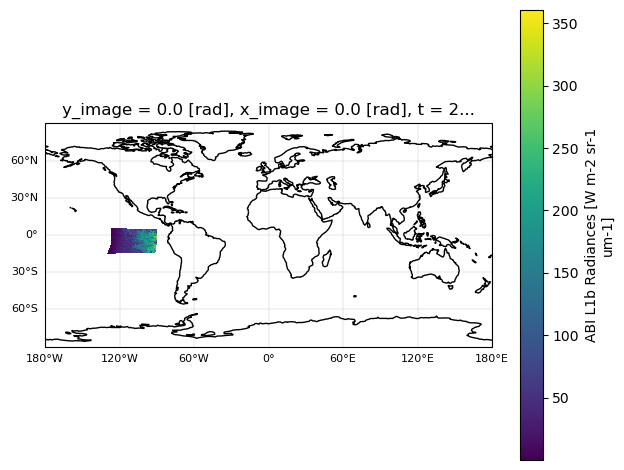

In [15]:
# in an even better way 
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())


ds_c.Rad.plot.imshow(ax=ax, x="x", y="y", transform=ds_c.FOV.crs)

#                                             facecolor='lightgray'))
ax.coastlines()
# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 
plt.tight_layout()
plt.show()

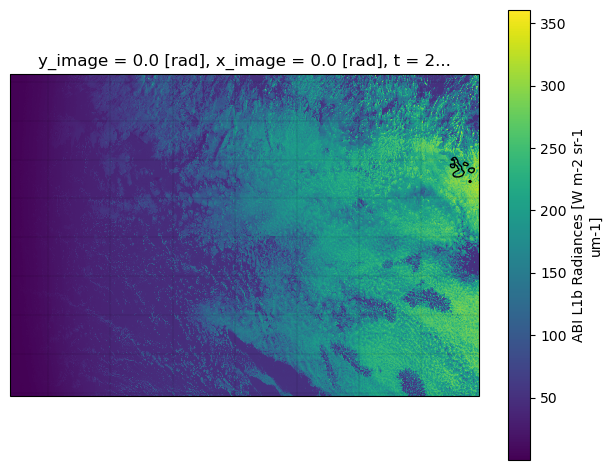

In [16]:
# in an even better way 
fig = plt.figure()
ax = plt.axes(projection=ds_c.FOV.crs)


ds_c.Rad.plot.imshow(ax=ax, x="x", y="y", transform=ds_c.FOV.crs)

#                                             facecolor='lightgray'))
ax.coastlines()
# Plot lat/lon grid 
gl = ax.gridlines(crs=ds_c.FOV.crs, draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 
plt.tight_layout()

In [17]:
def preprocess(ds):

    ds = ds.copy()

    ds = correct_goes16_satheight(ds)
    ds = correct_goes16_bands(ds)
    ds = add_goes16_crs(ds)
    
    
    # subset data
    bbox = (-130, -15, -90, 5)
    lon_bnds = (bbox[0], bbox[2])
    lat_bnds = (bbox[1], bbox[3])
    x_bnds, y_bnds = convert_lat_lon_to_x_y(ds.FOV.crs, lon=lon_bnds, lat=lat_bnds, )
    ds = ds.sortby("x").sortby("y")
    ds = ds.sel(
        y=slice(y_bnds[0], y_bnds[1]), 
        x=slice(x_bnds[0], x_bnds[1])
    )
    
    # resampling
    resolution = 1_000 # [m]
    method = "cubic"
    ds_subset = resample_rioxarray(ds, resolution=resolution, method=method)
    ds_subset = calc_latlon(ds_subset)

    # assign coordinates
    ds_subset = ds_subset[["Rad", "DQF"]]
    time_stamp = pd.to_datetime(ds.t.values)
    time_stamp = time_stamp.strftime("%Y-%m-%d %H:%M")
    band_attrs = ds.band.attrs
    band_wvl_attrs = ds.band_wavelength.attrs
    ds_subset[["Rad", "DQF"]] = ds_subset[["Rad", "DQF"]].expand_dims({"band":ds.band.values, "time":[time_stamp]})
    ds_subset = ds_subset.drop_vars(["t", "y_image", "x_image", "goes_imager_projection"])
    ds_subset.band.attrs = band_attrs
    ds_subset = ds_subset.assign_coords({"band_wavelength": ds.band_wavelength.values})
    ds_subset.band_wavelength.attrs = band_wvl_attrs

    return ds_subset

In [18]:
%%time
ds = xr.open_mfdataset(
    "/home/juanjohn/data/rs/goes16/raw/noaa-goes16/ABI-L1b-RadF/2018/274/14/OR_ABI-L1b-RadF-M4C02*"
)
ds_subset = preprocess(ds)
ds_subset

CPU times: user 3.26 s, sys: 299 ms, total: 3.56 s
Wall time: 3.29 s


<xarray.Dataset> Size: 150MB
Dimensions:          (band: 1, time: 1, y: 2068, x: 3014, band_wavelength: 1)
Coordinates:
  * x                (x) float64 24kB -4.645e+06 -4.644e+06 ... -1.632e+06
  * y                (y) float64 17kB 5.481e+05 5.471e+05 ... -1.519e+06
    latitude         (y, x) float64 50MB 5.304 5.304 5.304 ... -14.04 -14.04
    longitude        (y, x) float64 50MB -126.8 -126.8 -126.8 ... -90.51 -90.5
  * band             (band) int8 1B 2
  * time             (time) object 8B '2018-10-01 14:02'
  * band_wavelength  (band_wavelength) float32 4B 0.64
Data variables:
    Rad              (band, time, y, x) float32 25MB 0.6443 0.1685 ... nan nan
    DQF              (band, time, y, x) float32 25MB 0.0 0.0 0.0 ... nan nan nan
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    production_data_source:    Realtime
    timeline_id:               ABI Mode 4
    date_created:              2018-10-01T14:05:07.3Z
    time_coverage_start:       2018-10-01T14:00:22.4Z
    time_coverage_end:         2018-10-01T14:05:02.7Z
    id:                        f0161463-ab8d-4e15-91af-890acbb28956

#### Test II - A few Files

In [19]:
file_path = "/home/juanjohn/data/rs/goes16/raw/noaa-goes16/ABI-L1b-RadF/2018/274/14"
files = [
    # Band 1 - 10,848
    f"{file_path}/OR_ABI-L1b-RadF-M4C01_G16_s20182741400224_e20182741405027_c20182741405078.nc",
    # Band 2 - 21,696
    f"{file_path}/OR_ABI-L1b-RadF-M4C02_G16_s20182741400224_e20182741405027_c20182741405073.nc",
    # Band 4 - 5,424
    f"{file_path}/OR_ABI-L1b-RadF-M4C04_G16_s20182741400224_e20182741405028_c20182741405062.nc"
]

In [20]:
%%time
# open
ds = [xr.open_mfdataset(ifile, preprocess=preprocess, concat_dim="band", combine="nested") for ifile in files]
# reinterpolate to match coordinates of first image
ds = [ds[0]] + [ids.interp(x=ds[0].x, y=ds[0].y) for ids in ds[1:]]
# concatentate
ds = xr.concat(ds, dim="band")

CPU times: user 8.56 s, sys: 654 ms, total: 9.21 s
Wall time: 8.8 s


In [24]:
!ls /home/juanjohn/data/rs/goes/analysis

20202761609_goes16.nc  20202762009_goes16.nc


In [30]:
ds_ = xr.open_dataset("/home/juanjohn/data/rs/goes/analysis/20202761609_goes16.nc")
ds_

<xarray.Dataset> Size: 947MB
Dimensions:                          (x: 3014, y: 2067, time: 1,
                                      band_wavelength: 16, band: 16)
Coordinates:
  * x                                (x) float64 24kB -4.645e+06 ... -1.632e+06
  * y                                (y) float64 17kB 5.476e+05 ... -1.518e+06
  * time                             (time) <U16 64B '2020-10-02 16:05'
  * band_wavelength                  (band_wavelength) float32 64B 0.47 ... 1...
  * band                             (band) int8 16B 1 2 3 4 5 ... 13 14 15 16
    latitude                         (y, x) float64 50MB ...
    longitude                        (y, x) float64 50MB ...
    retrieval_local_zenith_angle     float32 4B ...
    retrieval_solar_zenith_angle     float32 4B ...
    quantitative_local_zenith_angle  float32 4B ...
    twilight_solar_zenith_angle      float32 4B ...
    cloud_mask                       (time, y, x) float64 50MB ...
Data variables:
    Rad                              (band, time, y, x) float32 399MB ...
    DQF                              (band, time, y, x) float32 399MB ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           RBU
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-02T16:09:55.4Z
    time_coverage_start:       2020-10-02T16:00:19.3Z
    time_coverage_end:         2020-10-02T16:09:50.1Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        27062453-6bd0-4259-9de9-28d3b20d7a07

In [29]:
ds_.close()

#### Test III - All The Files

In [21]:
list_of_files = get_list_filenames(file_path, "*.nc")

In [22]:
%%time
# open
ds = [xr.open_mfdataset(ifile, preprocess=preprocess, concat_dim="band", combine="nested") for ifile in list_of_files]
# reinterpolate to match coordinates of first image
ds = [ds[0]] + [ids.interp(x=ds[0].x, y=ds[0].y) for ids in ds[1:]]
# concatentate
ds = xr.concat(ds, dim="band")

CPU times: user 42.5 s, sys: 3.25 s, total: 45.7 s
Wall time: 45.2 s


In [23]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:          (x: 3014, y: 2067, time: 1, band_wavelength: 16, band: 16)
Coordinates:
  * x                (x) float64 24kB -4.645e+06 -4.644e+06 ... -1.632e+06
  * y                (y) float64 17kB 5.476e+05 5.466e+05 ... -1.518e+06
  * time             (time) object 8B '2018-10-01 14:02'
  * band_wavelength  (band_wavelength) float32 64B 0.47 0.64 0.865 ... 12.3 13.3
  * band             (band) int8 16B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    latitude         (band, y, x) float64 797MB 5.299 5.299 ... -14.04 -14.04
    longitude        (band, y, x) float64 797MB -126.8 -126.8 ... -90.5 -90.49
Data variables:
    Rad              (band, time, y, x) float64 797MB 0.8629 0.8629 ... nan nan
    DQF              (band, time, y, x) float64 797MB 0.0 0.0 0.0 ... nan nan
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    production_data_source:    Realtime
    timeline_id:               ABI Mode 4
    date_created:              2018-10-01T14:05:07.8Z
    time_coverage_start:       2018-10-01T14:00:22.4Z
    time_coverage_end:         2018-10-01T14:05:02.7Z
    id:                        6386f771-1da9-4d21-bab8-2db1b54c6cc5

## Stage 3

* Normalization
* Patching

#### Running Mean

In [25]:
save_dir_analysis = "/home/juanjohn/data/rs/goes16/analysis/"

In [26]:
def mean_preprocess(ds):
    # calculate the mean
    ds = ds["Rad"].mean(["x", "y"])
    return ds

In [27]:
ds_mean = xr.open_mfdataset(str(Path(save_dir_analysis).joinpath("*.nc")), preprocess=mean_preprocess, concat_dim="time", combine="nested")

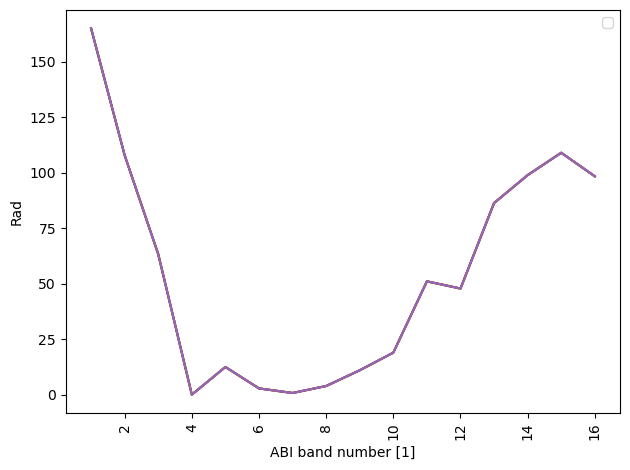

In [28]:
fig, ax = plt.subplots()
ds_mean.plot.line(x="band", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

In [29]:
ds_mean = ds_mean.mean(["time"])

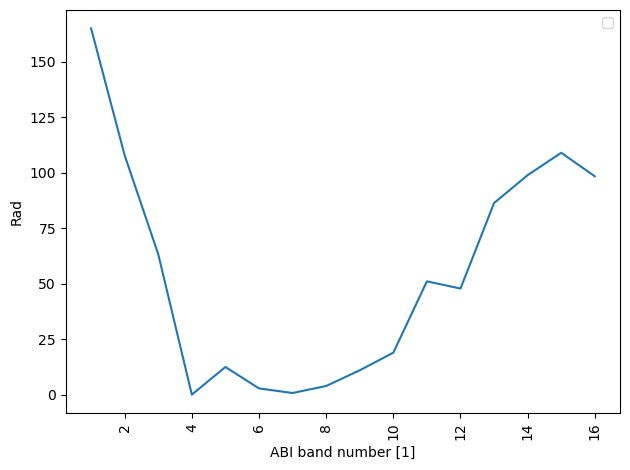

In [30]:
fig, ax = plt.subplots()
ds_mean.plot.line(x="band", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

In [31]:
def std_preprocess(ds):
    # calculate the mean
    ds = ((ds.Rad - ds_mean)**2).std(["x","y"])
    return ds

In [32]:
ds_std = xr.open_mfdataset(str(Path(save_dir_analysis).joinpath("*.nc")), preprocess=std_preprocess, concat_dim="time", combine="nested")

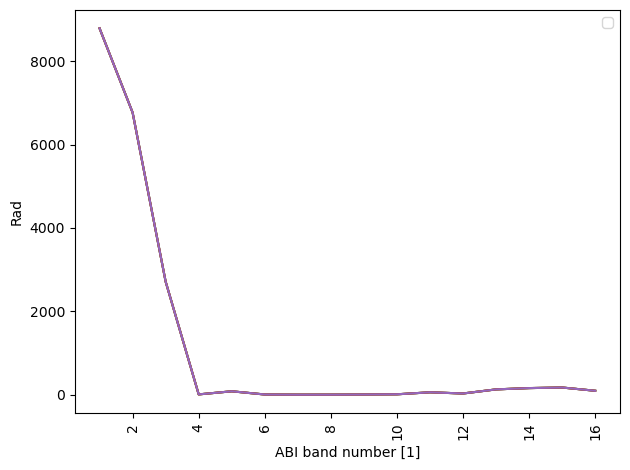

In [33]:
fig, ax = plt.subplots()
ds_std.plot.line(x="band", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

In [34]:
ds_std = ds_std.mean(["time"])

In [31]:
import pandas as pd

In [36]:
!ls /pool/usuarios/tanea/data/storylines/CMIP6/

data-storylines		    sm_sur  t2m   tmax95    z500
data-storylines_readme.txt  sst     tmax  tmax_std


In [38]:
df = pd.read_csv("/pool/usuarios/tanea/data/storylines/CMIP6/data-storylines")
df

,Unnamed: 0,variable,model,value,region,norm,stand
0,1,sm_sur,access.cm2,-2.035681,land,-0.443574,0.274103
1,2,sst,access.cm2,4.606706,ocean,1.003800,-0.124707
2,3,t2m,access.cm2,4.589266,global,NaN,NaN
3,4,z500.zonal,access.cm2,-5.039976,land,-1.098210,-2.257280
4,5,sm_sur,access.esm1.5,-1.579458,land,-0.415504,0.302174
...,...,...,...,...,...,...,...
107,108,z500.zonal,taiesm1,7.398502,land,1.509259,0.350188
108,109,sm_sur,ukesm1.0.ll,-4.522981,land,-0.802712,-0.085034
109,110,sst,ukesm1.0.ll,6.021916,ocean,1.068734,-0.059773
110,111,t2m,ukesm1.0.ll,5.634626,global,NaN,NaN


In [46]:
!ls /pool/usuarios/tanea/data/storylines/CMIP6/tmax/

delta_CC  historical  ssp585


In [45]:
ds = xr.open_mfdataset("/pool/usuarios/tanea/data/storylines/CMIP6/tmax/delta_CC/europe/delta_tmax_access-cm2_JJA-period-mean_europe.nc", use_cftime=True)
ds

<xarray.Dataset> Size: 2kB
Dimensions:  (time: 1, lon: 21, lat: 19)
Coordinates:
  * time     (time) object 8B 2100-07-17 00:00:00
  * lon      (lon) float64 168B -20.0 -17.5 -15.0 -12.5 ... 22.5 25.0 27.5 30.0
  * lat      (lat) float64 152B 26.25 28.75 31.25 33.75 ... 66.25 68.75 71.25
    height   float64 8B ...
Data variables:
    tasmax   (time, lat, lon) float32 2kB dask.array<chunksize=(1, 19, 21), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

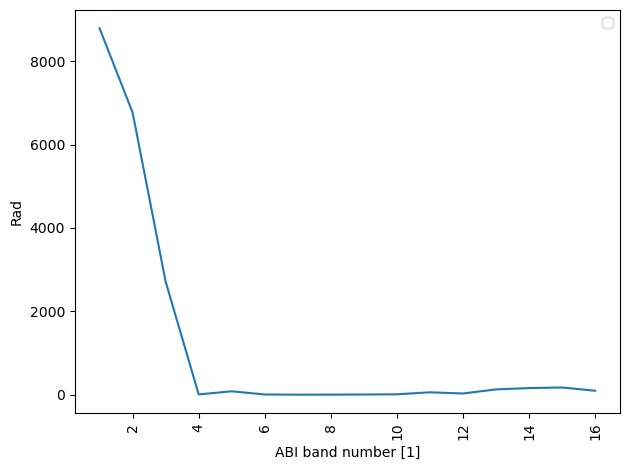

In [35]:
fig, ax = plt.subplots()
ds_std.plot.line(x="band", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

### Patching

In [36]:
from xrpatcher._src.base import XRDAPatcher

In [37]:
patches = dict(x=256, y=256)
strides = dict(x=64, y=64)
patcher = XRDAPatcher(da=ds.Rad, patches=patches, strides=strides)

In [38]:
len(patcher)

1276

In [39]:
ipatch = patcher[0]
ipatch

<xarray.DataArray 'Rad' (band: 16, time: 1, y: 256, x: 256)> Size: 8MB
array([[[[  0.86286354,   0.86286354,   0.86286354, ...,  13.04445839,
           13.04445839,  13.04445839],
         [  0.86286354,   0.86286354,   0.86286354, ...,  13.04445839,
           13.04445839,  13.04445839],
         [  0.86286354,   0.86286354,   0.86286354, ...,  13.04445839,
           13.04445839,  13.04445839],
         ...,
         [  1.67496872,   1.67496872,   0.86286354, ...,  14.66867256,
           14.66867256,  15.48077583],
         [  1.67496872,   1.67496872,   1.67496872, ...,  15.48077583,
           15.48077583,  14.66867256],
         [  0.86286354,   1.67496872,   0.86286354, ...,  14.66867256,
           14.66867256,  14.66867256]]],


       [[[  0.40585485,   0.32745574,   0.60445339, ...,   5.7194189 ,
            5.75942312,   5.87711209],
         [  0.56480587,   0.40675145,   0.48586897, ...,   5.87818931,
            5.71816058,   5.44152303],
         [  0.60373612,   0.3665658 ,   0.68482795, ...,   6.07606896,
...
          116.66930389, 115.03455078],
         [         nan, 117.19704437, 117.2498035 , ..., 116.66910301,
          116.66930389, 115.5085649 ],
         [         nan, 117.19713698, 117.24961835, ..., 116.66891787,
          116.66911866, 115.50856485]]],


       [[[         nan,  96.52262878,  96.52262878, ...,  99.3391633 ,
           99.3392525 ,  98.98784019],
         [         nan,  96.52262878,  96.52262878, ...,  99.16350555,
           99.16350555,  99.16350555],
         [         nan,  96.52293774,  96.52293774, ...,  99.1635054 ,
           99.16350555,  99.16350555],
         ...,
         [         nan,  97.75441747,  97.75503524, ...,  98.98766148,
           98.98775099,  98.81112198],
         [         nan,  97.40291595,  97.75494604, ...,  99.16332684,
           99.16350555,  98.63546424],
         [         nan,  97.40353388,  97.75463732, ...,  99.163327  ,
           99.16350555,  98.63577312]]]])
Coordinates:
  * x        (x) float64 2kB -4.645e+06 -4.644e+06 ... -4.391e+06 -4.39e+06
  * y        (y) float64 2kB 5.476e+05 5.466e+05 ... 2.936e+05 2.926e+05
  * time     (time) object 8B '2018-10-01 14:02'
  * band     (band) int8 16B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavelength
    sensor_band_bit_depth:  10
    valid_range:            [   0 1022]
    units:                  W m-2 sr-1 um-1
    resolution:             y: 0.000028 rad x: 0.000028 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF

In [63]:

for i, ipatch in enumerate(patcher):
    # save as numpy files
    np.savez(Path(save_dir_mlready).joinpath(f"{demo}_reflectance_patch_{i}.npz"), ipatch.values)
    np.savez(Path(save_dir_mlready).joinpath(f"{demo}_latitude_patch_{i}.npz"), ipatch.latitude.values)
    np.savez(Path(save_dir_mlready).joinpath(f"{demo}_longitude_patch_{i}.npz"), ipatch.longitude.values)
    np.savez(Path(save_dir_mlready).joinpath(f"{demo}_cloudmask_patch_{i}.npz"), ipatch.cloud_mask.values)
    break

In [46]:
mldata_dir = Path("/home/juanjohn/data/rs/goes16/mlready")

In [47]:
# !ls $mldata_dir

## Datasets, DataLoaders

In [40]:
from torch.utils.data import Dataset, DataLoader
from typing import Optional, Callable

In [88]:
class ImageDataReader(Dataset):
    def __init__(self, data_dir: str, ext: str=".npy", transforms: Optional[Callable]=None):
        self.data_dir = data_dir
        data_filenames = get_list_filenames(data_dir, ext)
        # filter files
        self.data = list(filter(lambda x: "reflectance" in x, data_filenames))
        self.lats = list(filter(lambda x: "latitude" in x, data_filenames))
        self.lons = list(filter(lambda x: "longitude" in x, data_filenames))
        self.masks = list(filter(lambda x: "cloudmask" in x, data_filenames))
        assert len(self.data) == len(self.lats) == len(self.lons) == len(self.masks)
        self.transforms = transforms

    def __getitem__(self, ind) -> np.ndarray:
        sample = {}
        sample["data"] = np.load(self.data[ind], mmap_mode="r+")
        sample["lats"] = np.load(self.lats[ind], mmap_mode="r+")
        sample["lons"] = np.load(self.lons[ind], mmap_mode="r+")
        sample["mask"] = np.load(self.masks[ind], mmap_mode="r+")
        if self.transforms is not None:
            sample = self.transforms(sample)
        return sample

    def __len__(self):
        return len(self.data)

In [89]:
ds = ImageDataReader("/home/juanjohn/data/rs/modis/mlready")

In [87]:
isample = ds[0]

#### DataLoader

In [83]:
dl = DataLoader(ds, batch_size=64, shuffle=False)

In [84]:
for isample in dl:
    break

In [85]:
isample["data"].shape

torch.Size([64, 1, 38, 256, 256])